In [307]:
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import networkx as nx
import numpy as np
from skan import Skeleton, summarize
import math
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from patchify import patchify, unpatchify
from tensorflow.keras.models import load_model
from skan import Skeleton, summarize
from skimage.morphology import skeletonize
import networkx as nx
import os
import pandas as pd
import math

In [316]:
Input_dataset = "raw"
Save_results_as = "Results_root_len.csv"

model_location = "Wesley_model.h5"

In [303]:
img_root = cv2.imread("Complex_images/Complex_image_root_2.png")
img_real = cv2.imread("Complex_images/Complex_img_2.png")

In [278]:
img_root = cv2.imread("pred_complex_root.png")
img_real = cv2.imread("Complex_root.png")

In [283]:
img_root = cv2.imread("im4/output_root_3.png")
img_real = cv2.imread("im4/output_3.png")

In [656]:
def crop_img(img):
    """ Crops an image based on edge detection using Canny.

    Args:
        image_name (str): The filename of the image to be processed.
    
    returns:
        output_image, diff_output_height, diff_output_width, y1, y2, x1, x2
        output_image(ndarray): The cropped image
        diff_output_height(int): the difference in height and width
        diff_output_width(int): the difference in width and height
        y1(int): the upper left corner of the edge
        y2(int): the down left corner of the edge
        x1(int): the upper right corner of the edge
        x2(int): the down right corner of the edge
    """
        

    input_image = img[:, 0:4100]

    canny = cv2.Canny(input_image, 0, 255)

    pts = np.argwhere(canny > 0)
    y1, x1 = pts.min(axis=0)
    y2, x2 = pts.max(axis=0)

    output_image = input_image[y1:y2, x1:x2]
    output_height = output_image.shape[0]
    output_width = output_image.shape[1]
    difference = abs(output_height - output_width)

    if output_height > output_width:
        diff_output_height = output_height - difference
        diff_output_width = output_width
    if output_height < output_width:
        diff_output_width = output_width - difference
        diff_output_height = output_height

    output_image = output_image[0:diff_output_height, 0:diff_output_width]
    return(output_image)

def error_fix(img):
    """
    Fix errors in an input image.

    This function takes an input image and performs the following operations to fix errors:
    1. Adjust the image dimensions to be square by cropping from the sides if necessary.
    2. Apply the 'crop_img' function twice to further crop the image.

    Parameters:
    img (numpy.ndarray): The input image as a NumPy array.

    Returns:
    numpy.ndarray: The fixed image after error correction.
    """
    diff_shape = round((img.shape[1] - img.shape[0]) / 2)
    diff_shape_1 = img.shape[1] - diff_shape
    img = img[:, diff_shape:diff_shape_1]
    output_img_temp = crop_img(img)
    output_img = crop_img(output_img_temp)
    return(output_img)

def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

def img_predictor(img, root_thr, model_type):
    """
    Predicts root presence in an image using a pre-trained model.

    This function takes an image and applies a pre-trained model to predict root presence. 
    It supports two model types, each with different preprocessing requirements. 
    The image is first padded, then split into patches, which are fed into the model for prediction. 
    The predictions are then reconstructed into a single image. The output is a binary mask representing 
    the predicted root presence and the original (or processed) image.

    Parameters:
    img (ndarray): The input image. Should be a NumPy array, format depending on model_type.
    root_thr (float): Threshold for converting the model's output to a binary mask. 
                      Values above this threshold are considered as root presence.
    model_type (int): Indicator of the model type to use. 
                      1 for the first model, 2 for the second model.

    Returns:
    tuple: A tuple containing:
        - predicted_root (ndarray): A binary mask of the same size as `img`, 
          indicating the presence of roots (1 for root, 0 for no root).
        - img (ndarray): The original or processed image, depending on `model_type`.

    Raises:
    Exception: If `model_type` is not 1 or 2, or other exceptions related to 
               loading models, image processing, or prediction.

    Note:
    This function requires certain external functions and models to be loaded:
    - `load_model` from an external library to load the pre-trained model.
    - `f1`, `iou` custom objects, likely used in the model.
    - `padder`, `patchify`, `unpatchify` for image preprocessing.
    - `cv2` for image manipulation.
    """
    
    if model_type == 1:
        root_mask_model = load_model('task_4_binary/models/all_trained_data_aug2.h5', custom_objects={'f1': f1, 'iou':iou})
    elif model_type == 2:
        root_mask_model = load_model(model_location, custom_objects={'f1': f1, 'iou':iou})
    img = padder(img, 256)

    if model_type == 1:
        patches = patchify(img, (256, 256, 3), step=256)
    if model_type == 2:
        patches = patchify(img, (256, 256), step=256)
    i = patches.shape[0]
    j = patches.shape[1]
    if model_type == 1:
        patches = patches.reshape(-1, 256, 256, 3)
    if model_type == 2:
        patches = patches.reshape(-1, 256, 256, 1)
    preds_root = root_mask_model.predict(patches/255)
    preds_root = preds_root.reshape(i, j, 256, 256)
    predicted_root = unpatchify(preds_root, (img.shape[0], img.shape[1]))
    predicted_root = predicted_root>root_thr
    predicted_root = predicted_root.astype(int)
    predicted_root = cv2.convertScaleAbs(predicted_root) 

    return(predicted_root, img)
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        total = K.sum(K.square(y_true),[1,2,3]) + K.sum(K.square(y_pred),[1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(f(y_true, y_pred), axis=-1)

def segmanter(predicted_root, img):
    
    """
    Segments the largest objects in different regions of an image based on a binary mask.

    This function takes a binary mask (predicted_root) indicating the presence of certain objects
    (e.g., roots in an image) and segments the largest objects in predefined regions of the mask. 
    The regions are based on the width of the image. It then extracts these objects from both the 
    binary mask and the original image. The function also plots the segmentation results for visualization.

    Parameters:
    predicted_root (ndarray): A binary mask image, where 1 represents the presence of an object.
    img (ndarray): The original image corresponding to the binary mask.

    Returns:
    tuple: A tuple containing:
        - full_imgs (list of ndarray): Segmented objects from the binary mask.
        - real_imgs (list of ndarray): Corresponding segmented objects from the original image.
        - object_presence (ndarray): A binary array indicating the presence of objects in each region.
        - x (list of int): The x-coordinate of the top-left corner of each segmented object.
        - y (list of int): The y-coordinate of the top-left corner of each segmented object.
        - w (list of int): The width of each segmented object.
        - h (list of int): The height of each segmented object.

    Note:
    - The function splits the image into 5 regions based on width and segments the largest object in each region.
    - It uses `cv2.connectedComponentsWithStats` for segmentation.
    - Plots are created using `matplotlib.pyplot`.
    - This function assumes certain threshold values and dimensions specific to the use case.
    """
     

    label_count, labels, stats, centroids = cv2.connectedComponentsWithStats(predicted_root)

    topmost_coordinates = np.full((label_count, 2), (0, labels.shape[0]), dtype=int)
    
    for y in range(labels.shape[0]):
        for x in range(labels.shape[1]):
            label = labels[y, x]
            if label != 0:  # Ignore the background
                if y < topmost_coordinates[label][1]:
                    topmost_coordinates[label] = [x, y]

    # Remove the entry for the background
    topmost_coordinates = topmost_coordinates[1:]

    large = []
    th_1 = np.sum(predicted_root[300:2500, 0:600]) * 0.1
    th_2 = np.sum(predicted_root[300:2500, 600:1200]) * 0.1
    th_3 = np.sum(predicted_root[300:2500, 1200:1600]) * 0.1
    th_4 = np.sum(predicted_root[300:2500, 1600:2200]) * 0.1
    th_5 = np.sum(predicted_root[300:2500, 2200:]) * 0.1

    image_width = predicted_root.shape[1]

    largest_area_1 = 0
    largest_area_2 = 0
    largest_area_3 = 0
    largest_area_4 = 0
    largest_area_5 = 0

    largest_label_1 = -1
    largest_label_2 = -1
    largest_label_3 = -1
    largest_label_4 = -1
    largest_label_5 = -1

    object_presence = np.zeros(5)


    for x in range(1, label_count):
        if (
            stats[x, cv2.CC_STAT_TOP] < 1500
            and stats[x, cv2.CC_STAT_LEFT] >= 10
            and stats[x, cv2.CC_STAT_LEFT] + stats[x, cv2.CC_STAT_WIDTH] <= image_width - 10
            and stats[x, cv2.CC_STAT_TOP] > 200
            and stats[x, cv2.CC_STAT_AREA] > 100
            
        ):
            if stats[x, cv2.CC_STAT_TOP] < 600 or stats[x, cv2.CC_STAT_AREA] > 3000:
                if (
                    stats[x, cv2.CC_STAT_AREA] > th_1
                    and topmost_coordinates[x-1][0] < 600
                ):
                    area_1 = stats[x, cv2.CC_STAT_AREA]
                    if area_1 > largest_area_1:
                        largest_area_1 = area_1
                        largest_label_1 = x

                if (
                    stats[x, cv2.CC_STAT_AREA] > th_2
                    and topmost_coordinates[x-1][0] > 600
                    and topmost_coordinates[x-1][0] < 1200
                ):
                    area_2 = stats[x, cv2.CC_STAT_AREA]
                    if area_2 > largest_area_2:
                        largest_area_2 = area_2
                        largest_label_2 = x


                if (
                    stats[x, cv2.CC_STAT_AREA] > th_3
                    and topmost_coordinates[x-1][0] > 1200
                    and topmost_coordinates[x-1][0] < 1700
                ):
                    area_3 = stats[x, cv2.CC_STAT_AREA]
                    if area_3 > largest_area_3:
                        largest_area_3 = area_3
                        largest_label_3 = x

                if (
                    stats[x, cv2.CC_STAT_AREA] > th_4
                    and topmost_coordinates[x-1][0] > 1700
                    and topmost_coordinates[x-1][0] < 2300
                ):
                    area_4 = stats[x, cv2.CC_STAT_AREA]
                    if area_4 > largest_area_4:
                        largest_area_4 = area_4
                        largest_label_4 = x

                if (
                    stats[x, cv2.CC_STAT_AREA] > th_5
                    and topmost_coordinates[x-1][0] > 2300
                ):
                    area_5 = stats[x, cv2.CC_STAT_AREA]
                    if area_5 > largest_area_5:
                        largest_area_5 = area_5
                        largest_label_5 = x


    if largest_label_1 != -1:
        large.append(largest_label_1)
        object_presence[0] = 1

    if largest_label_2 != -1:
        large.append(largest_label_2)
        object_presence[1] = 1
        
    if largest_label_3 != -1:
        large.append(largest_label_3)
        object_presence[2] = 1
    
    if largest_label_4 != -1:
        large.append(largest_label_4)
        object_presence[3] = 1

    if largest_label_5 != -1:
        large.append(largest_label_5)
        object_presence[4] = 1

    black_img1 = np.zeros_like(labels, dtype=np.uint8)
    for x, component_idx in enumerate(large):
        color = x + 1
        black_img1[labels == component_idx] = color

    x = []
    y = []
    w = []
    h = []

    for i in large:
        x.append(stats[i, 0])
        y.append(stats[i, 1])
        w.append(stats[i, 2])
        h.append(stats[i, 3])


    full_imgs = []
    real_imgs = []

    for i in range(len(large)):
        full_imgs.append(black_img1[y[i]:y[i]+h[i], x[i]:x[i]+w[i]])
        real_imgs.append(img[y[i]:y[i]+h[i], x[i]:x[i]+w[i]])

    return(full_imgs, real_imgs, object_presence, x, y, w, h, black_img1)

def img_drawer(main_root, second_root, im_with_circles):
    kernel_size = 3
    kernel = np.ones((kernel_size,kernel_size),np.uint8)

    dilated_img_main = cv2.dilate(main_root, kernel, iterations = 1)
    dilated_img_second = cv2.dilate(second_root, kernel, iterations = 1)

    main_bin_img = dilated_img_main


    main_binary_img = main_bin_img / np.max(main_bin_img)

    secondary_bin_img = dilated_img_second
    secondary_binary_img = secondary_bin_img / np.max(secondary_bin_img)

    binary_img_rgb_secondary = np.dstack((secondary_binary_img, np.zeros_like(secondary_binary_img), np.zeros_like(secondary_binary_img)))

    binary_img_rgb_main = np.dstack((np.zeros_like(main_binary_img), main_binary_img, np.zeros_like(main_binary_img)))

    overlay_img = ((im_with_circles / 255) * 1 + binary_img_rgb_secondary * 0.4).clip(0,1)
    overlay_img = (overlay_img * 1 + binary_img_rgb_main * 0.4).clip(0,1)


    return overlay_img

def img_feeder(img, img_color):
    """
    Processes an image to identify root structures, calculate their lengths, and visualize the results.

    This function performs several steps to analyze root structures in an input image:
    1. Depending on the size of the input image, it either fixes errors or crops the image.
    2. Predicts root locations in the processed image.
    3. Segments the image to isolate individual roots and their corresponding real images.
    4. If necessary, applies a smaller pipeline for further processing.
    5. For each detected root, calculates its length and generates a visual representation of the root skeleton.
    6. Overlays the skeleton on the original image, highlighting the start and end points of each root.

    Parameters:
    img (numpy.ndarray): The input image to be processed. It should be a grayscale or colored image of root structures.

    Returns:
    tuple: A tuple containing the following:
        - A list of images with circles drawn at the start and end points of each root.
        - A list of the lengths of each identified root.
        - An image with the combined visualizations of all roots, their skeletons, and start/end points marked.

    Note:
    This function depends on several other functions (`error_fix`, `crop_img`, `img_predictor`, `segmanter`, `small_pipeline`, `root_length_calc`) and external libraries such as OpenCV and NumPy. Ensure all dependent functions and libraries are available and properly imported.
    """
    if img.shape[0] < 3000:
        cropped_img = error_fix(img)
        cropped_img_color = error_fix(img_color)
    else:
        cropped_img = crop_img(img)
        cropped_img_color = crop_img(img_color)

    cropped_img_color = padder(cropped_img_color, 256)
    
    predicted_root, output_img = img_predictor(cropped_img, root_thr=0.05, model_type=2)
    root_imgs, real_imgs, object_presence, x, y, w, h, predicted_root = segmanter(predicted_root, cropped_img_color)

    skeletons = []

    
    sub_roots = []

    end_img = output_img.copy()
    end_img = cv2.cvtColor(end_img, cv2.COLOR_GRAY2BGR)
 
    sub_imgs = []
    skeletons = []
    branch_datas = []
    second_roots = []
    im_with_circles = []
    main_roots = []
    overlay_imgs = []

    full_img = np.zeros_like(cropped_img_color, dtype=np.uint8)[:,:,:1]
    full_img = np.squeeze(full_img)
    second_full_img = np.zeros_like(cropped_img_color, dtype=np.uint8)[:,:,:1]
    second_full_img = np.squeeze(second_full_img)

    i = 0
    for object in object_presence:
        if object == 1:
            sub_root, im_with_circle, simple_skeleton_branch_data, skeleton, second_root, main_root, G, image, paths, skel_obj, plant_1= root_length_calc(root_imgs[i], real_imgs[i])
            
            second_root = plant_1
            
            #sub_root = sum(sub_root)
            sub_roots.append(sub_root)
            skeletons.append(skeleton)
            main_roots.append(main_root)
            second_roots.append(second_root)
            im_with_circles.append(im_with_circle)


           
            full_img[y[i]: y[i] + main_root.shape[0], x[i]: x[i] + main_root.shape[1]] = main_root
            second_full_img[y[i]: y[i] + second_root.shape[0], x[i]: x[i] + second_root.shape[1]] = second_root    
            
            overlay_img = img_drawer(full_img, second_full_img, cropped_img_color)



            i += 1          
            
        else:
            sub_roots.append(0)

    return sub_roots, im_with_circles, main_roots, second_roots, overlay_img, full_img


In [4]:
def get_x_y(row):
    x1 = row["image-coord-src-0"]
    y1 = row["image-coord-src-1"]

    x2 = row["image-coord-dst-0"]
    y2 = row["image-coord-dst-1"]
    
    return x1, y1, x2, y2

In [5]:
def calculate_angle(row):
    x1, y1, x2, y2 = get_x_y(row)
    delta_x = x2 - x1
    delta_y = y2 - y1

    angle_radians = math.atan2(delta_y, delta_x)

    angle_degrees = math.degrees(angle_radians)
    return angle_degrees

In [6]:
def mark_path(cords, image):
    for x in cords:
        image[x[0], x[1]] = 1
    return image

In [7]:
def get_plant_section(img, simple_skeleton_branch_data, plants):
    width = img.shape[1]
    section_width = width / plants

    for index, row in simple_skeleton_branch_data.iterrows():
        section = int(row["image-coord-src-1"] // section_width) + 1
        simple_skeleton_branch_data.at[index, "section"] = section

    return simple_skeleton_branch_data["section"]

In [106]:
def calc_root_ends(simple_skeleton_branch_data, G, num_plants):
    df_bottom = pd.DataFrame(columns=simple_skeleton_branch_data.columns)
    df_top = pd.DataFrame(columns=simple_skeleton_branch_data.columns)

    if num_plants > 1:
        for x in (np.sort(simple_skeleton_branch_data["section"].unique())):

            section_1_data = simple_skeleton_branch_data[simple_skeleton_branch_data['section'] == x]

            highest_values = section_1_data.nlargest(5, 'image-coord-dst-0')
            top_root = section_1_data.nsmallest(1, 'image-coord-dst-0')
            start_node = top_root["node-id-src"].values[0]

            for index, row in highest_values.iterrows():
                end_node = row["node-id-dst"]
                path = nx.dijkstra_path(G, start_node, int(end_node), weight='branch-distance')
                degree_count = 0
                for x in path:
                    row = simple_skeleton_branch_data[simple_skeleton_branch_data['node-id-dst'] == x]
                    degree_count += abs(row["angle"].sum())
                degrees_count = degree_count / len(path)
                highest_values.at[index, "degree_count"] = degrees_count

            bottom_root = highest_values.nsmallest(1, 'degree_count')


            df_bottom = pd.concat([df_bottom, bottom_root])
            df_top = pd.concat([df_top, top_root])
    else:
        df_top = simple_skeleton_branch_data.nsmallest(1, 'node-id-src')
        df_bottom = simple_skeleton_branch_data.nlargest(1, 'node-id-dst')




    return df_bottom, df_top

In [9]:
def get_num_plants(skeleton):
    width = skeleton.shape[1]
    if math.floor(width / 500) == 0:
        return 1
    else:
        return(math.floor(width / 500))

In [198]:
def get_paths(top_roots, bottom_roots, G):
    paths = []
    x =0 
    for index, row in top_roots.iterrows():
        path = nx.dijkstra_path(G, bottom_roots["node-id-src"].iloc[x], top_roots["node-id-dst"].iloc[x], weight='branch-distance')
        paths.append(path)
        x += 1

        
    return paths

In [166]:
def remove_least_skeleton(simple_skeleton_branch_data):
    if len(simple_skeleton_branch_data["skeleton-id"].unique()) > 1:
        # Group by 'skeleton-id' and count
        counts = simple_skeleton_branch_data.groupby('skeleton-id').size()
        
        # Find the 'skeleton-id' with the least count
        least_skeleton_id = counts.idxmin()
        
        # Drop the rows with the 'skeleton-id' that has the least count
        simple_skeleton_branch_data = simple_skeleton_branch_data[simple_skeleton_branch_data['skeleton-id'] != least_skeleton_id]
    
    return simple_skeleton_branch_data

In [517]:
for x in simple_skeleton_branch_data["section"].unique():
    print(int(x))

5
3
4
2
1


In [623]:
def get_second_root_per_plant(skeleton, simple_skeleton_branch_data, paths, skeleton_obj):
    plants = []
    

    i = 0
    plant = np.zeros_like(skeleton)
    for index, row in simple_skeleton_branch_data.iterrows():
        if row["section"] == 1:
            if row["node-id-src"] in paths[0]:
                if abs(row["angle"]) > 20:
                    cord = skeleton_obj.path_coordinates(i)
                    plant = mark_path(cord, plant)


        i +=1
        plants.append(plant)

    return plants

In [625]:
def root_length_calc(image, real_img):
    skeleton = skeletonize(image)
    skeleton_obj = Skeleton(skeleton)
    simple_skeleton_branch_data = summarize(skeleton_obj)

    simple_skeleton_branch_data = remove_least_skeleton(simple_skeleton_branch_data)
    

    G = nx.from_pandas_edgelist(simple_skeleton_branch_data, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')

    branches = len(simple_skeleton_branch_data)

    second_roots = np.zeros_like(image)
    main_root = np.zeros_like(image)

    num_plants = get_num_plants(skeleton)

    simple_skeleton_branch_data["angle"] = simple_skeleton_branch_data.apply(calculate_angle, axis=1)

    simple_skeleton_branch_data["section"] = get_plant_section(skeleton, simple_skeleton_branch_data, num_plants)

    top_roots, bottom_roots = calc_root_ends(simple_skeleton_branch_data, G, num_plants)

    paths = get_paths(top_roots, bottom_roots, G)
    for i in range(branches):
        end_node = simple_skeleton_branch_data["node-id-dst"].iloc[i]
       
        cord = skeleton_obj.path_coordinates(i)

        if any(end_node in sublist for sublist in paths):
            main_root = mark_path(cord, main_root)
        else:
            second_roots = mark_path(cord, second_roots) 
    
    sub_roots = np.sum(second_roots)

    plants = get_second_root_per_plant(skeleton, simple_skeleton_branch_data, paths, skeleton_obj)



    return sub_roots, real_img, simple_skeleton_branch_data, skeleton, second_roots, main_root, G, image, paths, skeleton_obj, plants

In [261]:
skeleton = skeletonize(img_root)
skeleton_obj = Skeleton(skeleton)
simple_skeleton_branch_data = summarize(skeleton_obj)


In [640]:
sub_roots, im_with_circles, simple_skeleton_branch_data, skeleton, second_roots, main_root, G, image, paths, skeleton_obj, plant_1= root_length_calc(img_root, img_real)

C:\Users\wesle\AppData\Local\Temp\ipykernel_2424\2781812532.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_bottom = pd.concat([df_bottom, bottom_root])
C:\Users\wesle\AppData\Local\Temp\ipykernel_2424\2781812532.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_top = pd.concat([df_top, top_root])


In [653]:
i = 0
plant_1 = np.zeros_like(skeleton)
for index, row in simple_skeleton_branch_data.iterrows():
    if row["section"] == 1:
        if row["node-id-src"] in paths[0]:
            if abs(row["angle"]) > 20:
                cord = skeleton_obj.path_coordinates(i)
                plant_1 = mark_path(cord, plant_1)

    i +=1

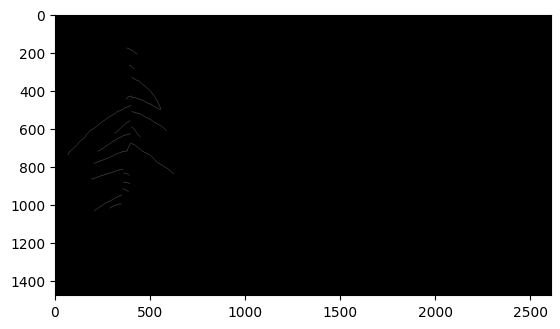

In [654]:
plt.imshow(plant_1*255)

In [650]:
img_real = cv2.imread("Complex_images/Complex_img_3.png", 0 )
img_real_color = cv2.imread("Complex_images/Complex_img_3.png")
sub_roots, im_with_circles, main_roots, second_roots, overlay_img, full_img = img_feeder(img_real, img_real_color)

4/4 [==============================] - 1s 125ms/step


C:\Users\wesle\AppData\Local\Temp\ipykernel_2424\2781812532.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_bottom = pd.concat([df_bottom, bottom_root])
C:\Users\wesle\AppData\Local\Temp\ipykernel_2424\2781812532.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_top = pd.concat([df_top, top_root])


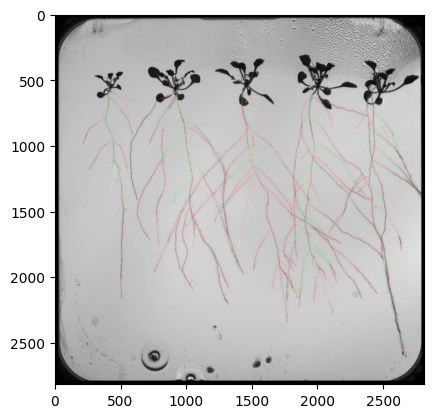

In [651]:
plt.imshow(overlay_img)